#Import Library


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

warnings.filterwarnings('ignore')

#Dataset

In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/hfeez/Client-churn-rate-in-Telecom-sector/main/Data_Train.csv ")
test = pd.read_csv("https://raw.githubusercontent.com/gustavsmnt/Churn-Prediction/main/Data%20Test.csv ")

In [3]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [4]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


#EDA 

##Data Info

In [5]:
print("Total Rows :", train.shape[0])
print("Total Features :", train.shape[1])
print("Duplicate Value:", train.duplicated().sum())
list_train = []
for col in train.columns:
    list_train.append([col, train[col].dtype, train[col].isna().sum(), 100*train[col].isna().sum()/len(train[col])])
train_desc = pd.DataFrame(data=list_train, columns=['Feature','Data Type','Null', 'Null (%)'])
train_desc

Total Rows : 4250
Total Features : 20
Duplicate Value: 0


,Feature,Data Type,Null,Null (%)
0,state,object,0,0.0
1,account_length,int64,0,0.0
2,area_code,object,0,0.0
3,international_plan,object,0,0.0
4,voice_mail_plan,object,0,0.0
5,number_vmail_messages,int64,0,0.0
6,total_day_minutes,float64,0,0.0
7,total_day_calls,int64,0,0.0
8,total_day_charge,float64,0,0.0
9,total_eve_minutes,float64,0,0.0


##Data Shape

In [6]:
train.shape, test.shape

((4250, 20), (750, 20))

##Categorical and Numerical Columns

###Numerical Columns

In [7]:
numerical_features = train.select_dtypes(include = [np.number])
numerical_features.columns

Index(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls'],
      dtype='object')

###Categorical Columns

In [10]:
categorical_features = train.select_dtypes(include = object)
categorical_features.columns

Index(['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn'], dtype='object')

##Distribution on Target

no     3652
yes     598
Name: churn, dtype: int64

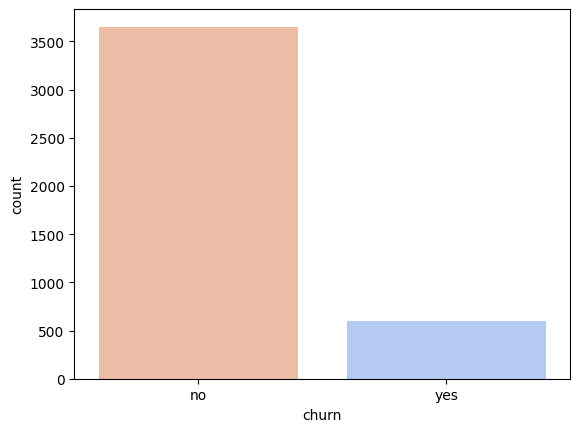

In [11]:
sns.countplot(x='churn', data=train, palette='coolwarm_r')
train['churn'].value_counts()

##Change Target Label to Numerical

In [12]:
train['churn'].replace(['yes', 'no'],[1, 0], inplace=True)

##Relationship between Columns

<AxesSubplot: >

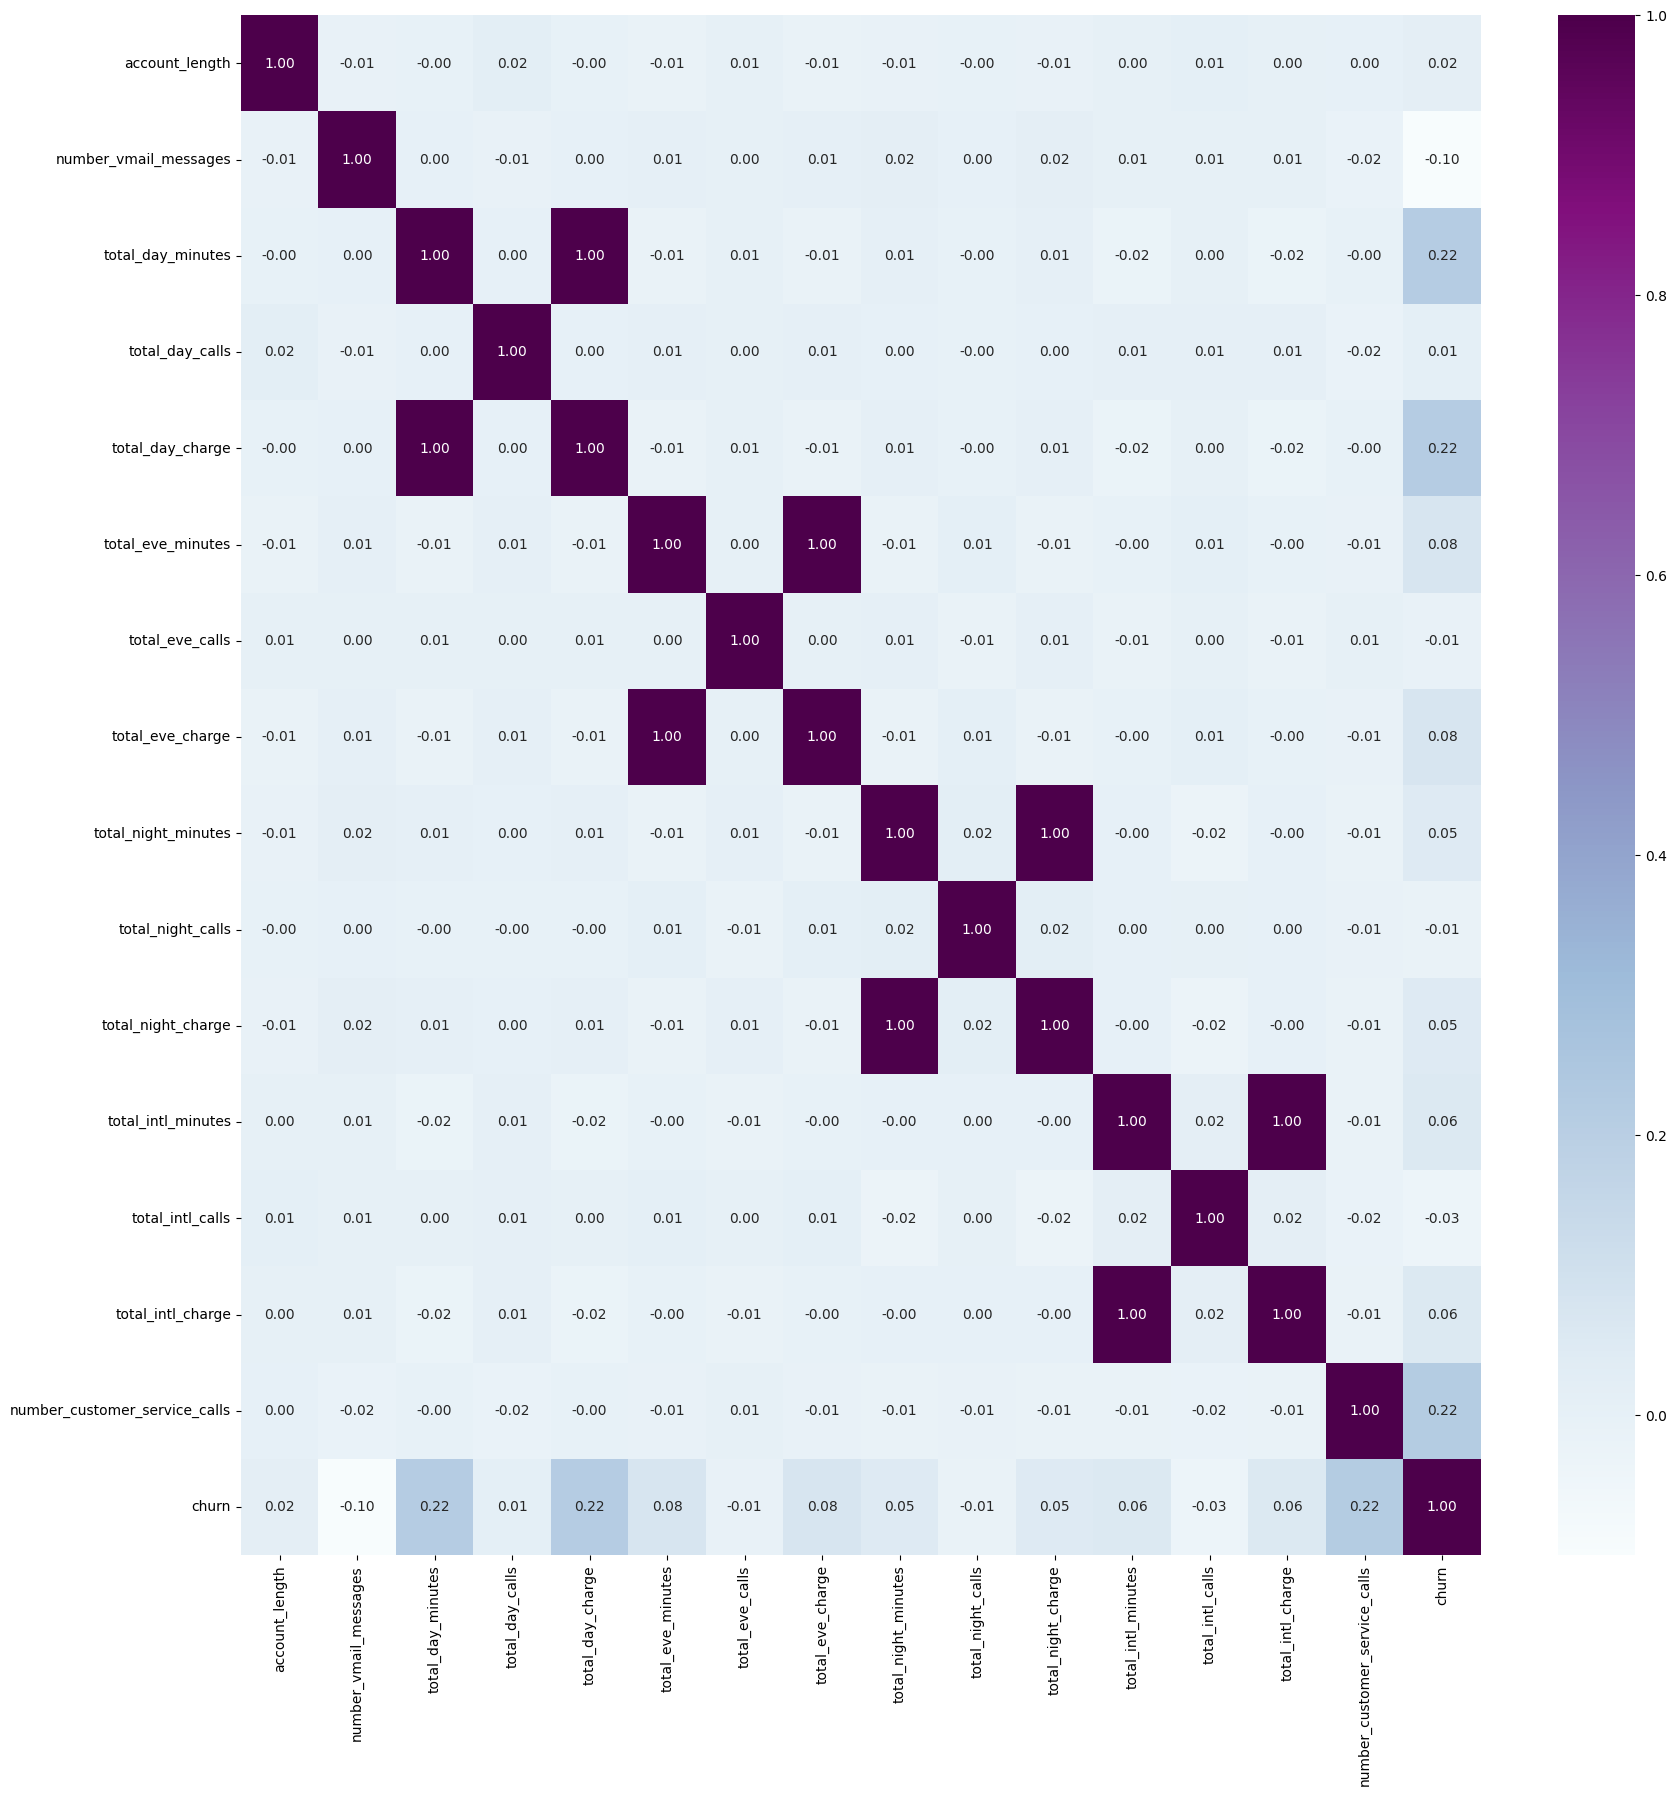

In [13]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),annot=True,cmap='BuPu',fmt='.2f')

In [14]:
correlations = (train.select_dtypes(exclude=object)
                .corr()
                .dropna(how="all", axis=0)
                .dropna(how="all", axis=1)
)

In [15]:
correlations['churn'].sort_values(ascending=False)

churn                            1.000000
number_customer_service_calls    0.221220
total_day_minutes                0.215272
total_day_charge                 0.215263
total_eve_minutes                0.078855
total_eve_charge                 0.078852
total_intl_minutes               0.055186
total_intl_charge                0.055177
total_night_minutes              0.046647
total_night_charge               0.046641
account_length                   0.019378
total_day_calls                  0.011640
total_eve_calls                 -0.006817
total_night_calls               -0.012699
total_intl_calls                -0.034334
number_vmail_messages           -0.100347
Name: churn, dtype: float64

#Preprocessor

In [18]:
X = train.drop(columns="churn")
y = train.churn


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2975, 19), (1275, 19), (2975,), (1275,))

##Column Transformer

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls']),
        ('cat', OneHotEncoder(), ['state', 'area_code', 'international_plan', 'voice_mail_plan'])
    ])

##Handling Imbalanced Data

In [20]:
smt = SMOTE(sampling_strategy = 'not majority', random_state = 42)

#Models

##Logistic Regression

In [21]:
pipeLR = imbPipeline([
    ("prep", preprocessor),
    ("smt",smt),
    ("algo", LogisticRegression(random_state=42))
])

In [22]:
pipeLR.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['account_length',
                                                   'number_vmail_messages',
                                                   'total_day_minutes',
                                                   'total_day_calls',
                                                   'total_day_charge',
                                                   'total_eve_minutes',
                                                   'total_eve_calls',
                                                   'total_eve_charge',
                                                   'total_night_minutes',
                                                   'total_night_calls',
                                                   'total_night_charge',
                                                   'total_intl_minutes',
                                                   'total_intl_calls',
                                                   'total_intl_charge',
                                                   'number_customer_service_calls']),
                                                 ('cat', OneHotEncoder(),
                                                  ['state', 'area_code',
                                                   'international_plan',
                                                   'voice_mail_plan'])])),
                ('smt',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('algo', LogisticRegression(random_state=42))])

In [23]:
pipeLR.score(X_test, y_test)

0.7647058823529411

In [24]:
y_pred = pipeLR.predict(X_test)

In [25]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)

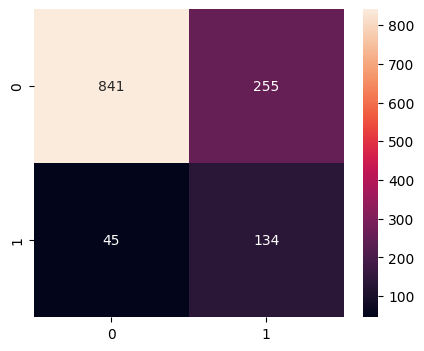

In [26]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="g")
plt.show()

## SVM

In [27]:
pipeSVM = imbPipeline([
    ("prep", preprocessor),
    ("smt",smt),
    ("algo", svm.SVC(random_state=42, probability=True))
])

In [28]:
pipeSVM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['account_length',
                                                   'number_vmail_messages',
                                                   'total_day_minutes',
                                                   'total_day_calls',
                                                   'total_day_charge',
                                                   'total_eve_minutes',
                                                   'total_eve_calls',
                                                   'total_eve_charge',
                                                   'total_night_minutes',
                                                   'total_night_calls',
                                                   'total_night_charge',
                                                   'total_intl_minutes',
                                                   'total_intl_calls',
                                                   'total_intl_charge',
                                                   'number_customer_service_calls']),
                                                 ('cat', OneHotEncoder(),
                                                  ['state', 'area_code',
                                                   'international_plan',
                                                   'voice_mail_plan'])])),
                ('smt',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('algo', SVC(probability=True, random_state=42))])

In [29]:
pipeSVM.score(X_test, y_test)

0.7898039215686274

In [30]:
y_pred = pipeSVM.predict(X_test)


In [31]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)

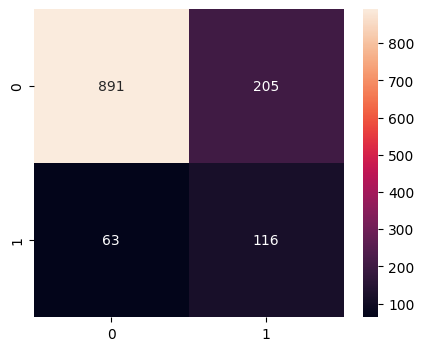

In [32]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="g")
plt.show()

## Random Forest

In [33]:
pipeRF = imbPipeline([
    ("prep", preprocessor),
    ("smt",smt),
    ("algo", RandomForestClassifier(random_state=42))
])

In [34]:
pipeRF.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['account_length',
                                                   'number_vmail_messages',
                                                   'total_day_minutes',
                                                   'total_day_calls',
                                                   'total_day_charge',
                                                   'total_eve_minutes',
                                                   'total_eve_calls',
                                                   'total_eve_charge',
                                                   'total_night_minutes',
                                                   'total_night_calls',
                                                   'total_night_charge',
                                                   'total_intl_minutes',
                                                   'total_intl_calls',
                                                   'total_intl_charge',
                                                   'number_customer_service_calls']),
                                                 ('cat', OneHotEncoder(),
                                                  ['state', 'area_code',
                                                   'international_plan',
                                                   'voice_mail_plan'])])),
                ('smt',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('algo', RandomForestClassifier(random_state=42))])

In [35]:
pipeRF.score(X_test, y_test)

0.9427450980392157

In [36]:
y_pred = pipeRF.predict(X_test)

In [37]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)

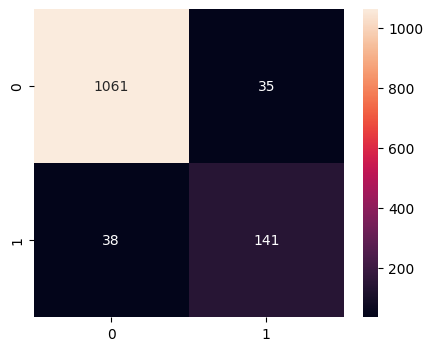

In [38]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="g")
plt.show()

## KNN

In [39]:
pipeKNN = imbPipeline([
    ("prep", preprocessor),
    ("smt",smt),
    ("algo", KNeighborsClassifier(n_neighbors=3))
])

In [40]:
pipeKNN.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['account_length',
                                                   'number_vmail_messages',
                                                   'total_day_minutes',
                                                   'total_day_calls',
                                                   'total_day_charge',
                                                   'total_eve_minutes',
                                                   'total_eve_calls',
                                                   'total_eve_charge',
                                                   'total_night_minutes',
                                                   'total_night_calls',
                                                   'total_night_charge',
                                                   'total_intl_minutes',
                                                   'total_intl_calls',
                                                   'total_intl_charge',
                                                   'number_customer_service_calls']),
                                                 ('cat', OneHotEncoder(),
                                                  ['state', 'area_code',
                                                   'international_plan',
                                                   'voice_mail_plan'])])),
                ('smt',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('algo', KNeighborsClassifier(n_neighbors=3))])

In [41]:
pipeKNN.score(X_test, y_test)

0.7466666666666667

In [42]:
y_pred = pipeKNN.predict(X_test)

In [43]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)

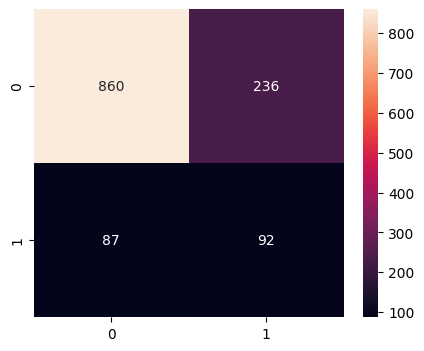

In [44]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="g")
plt.show()

## Gradient Boosting


In [45]:
pipeGBM = imbPipeline([
    ("prep", preprocessor),
    ("smt",smt),
    ("algo", GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                    max_depth=5, random_state=0))
])

In [46]:
pipeGBM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['account_length',
                                                   'number_vmail_messages',
                                                   'total_day_minutes',
                                                   'total_day_calls',
                                                   'total_day_charge',
                                                   'total_eve_minutes',
                                                   'total_eve_calls',
                                                   'total_eve_charge',
                                                   'total_night_minutes',
                                                   'total_night_calls',
                                                   'total_night_charge',
                                                   'total_intl_minutes',
                                                   'total_intl_calls',
                                                   'total_intl_charge',
                                                   'number_customer_service_calls']),
                                                 ('cat', OneHotEncoder(),
                                                  ['state', 'area_code',
                                                   'international_plan',
                                                   'voice_mail_plan'])])),
                ('smt',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('algo',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                            random_state=0))])

In [47]:
pipeGBM.score(X_test, y_test)

0.9380392156862745

In [48]:
y_pred = pipeGBM.predict(X_test)

In [49]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)

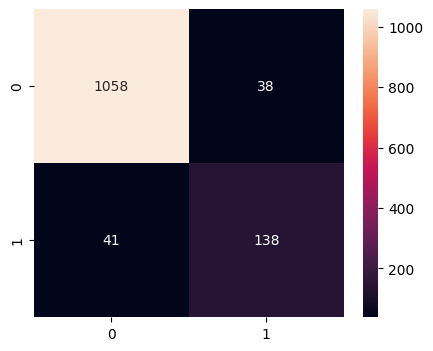

In [50]:
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="g")
plt.show()

# Metrics Results

In [51]:
LR_scores, SVM_scores, RF_scores, KNN_scores, GBM_scores = {}, {}, {}, {}, {}

for scores, classifier in zip(
    (LR_scores, SVM_scores, RF_scores, KNN_scores, GBM_scores), (pipeLR, pipeSVM, pipeRF, pipeKNN, pipeGBM)
):
    name = classifier[-1].__class__.__name__
    print("Step:".ljust(10), f"{name}")
    
    probabilities = cross_val_predict(classifier, X, y, method="predict_proba")
    positive_class_proba = probabilities[:, 1]
    predictions = np.argmax(probabilities, axis=1)

    scores["Classifier"] = name
    scores["Accuracy"] = accuracy_score(y, predictions)
    scores["Precision"] = precision_score(y, predictions)
    scores["Recall"] = recall_score(y, predictions)
    scores["Specificity"] = recall_score(y, predictions, pos_label=0)
    scores["F1"] = f1_score(y, predictions)
    scores["ROC-AUC"] = roc_auc_score(y, positive_class_proba)
    scores["FPR-TPR-Threshold"] = roc_curve(y, positive_class_proba)

Step:      LogisticRegression
Step:      SVC
Step:      RandomForestClassifier
Step:      KNeighborsClassifier
Step:      GradientBoostingClassifier


In [52]:
metrics = pd.DataFrame(
    {
        LR_scores["Classifier"]: [
            LR_scores["Accuracy"],
            LR_scores["Precision"],
            LR_scores["Recall"],
            LR_scores["Specificity"],
            LR_scores["F1"],
            LR_scores["ROC-AUC"],
        ],
        SVM_scores["Classifier"]: [
            SVM_scores["Accuracy"],
            SVM_scores["Precision"],
            SVM_scores["Recall"],
            SVM_scores["Specificity"],
            SVM_scores["F1"],
            SVM_scores["ROC-AUC"],
        ],
        RF_scores["Classifier"]: [
            RF_scores["Accuracy"],
            RF_scores["Precision"],
            RF_scores["Recall"],
            RF_scores["Specificity"],
            RF_scores["F1"],
            RF_scores["ROC-AUC"],
        ],
        KNN_scores["Classifier"]: [
            KNN_scores["Accuracy"],
            KNN_scores["Precision"],
            KNN_scores["Recall"],
            KNN_scores["Specificity"],
            KNN_scores["F1"],
            KNN_scores["ROC-AUC"],
        ],
        GBM_scores["Classifier"]: [
            GBM_scores["Accuracy"],
            GBM_scores["Precision"],
            GBM_scores["Recall"],
            GBM_scores["Specificity"],
            GBM_scores["F1"],
            GBM_scores["ROC-AUC"],
        ]
    },
    index=["Accuracy", "Precision", "Recall", "Specificity", "F1", "ROC-AUC"],
)

DF_CMAP = sns.light_palette("#2a357d", as_cmap=True)
metrics.T.style.background_gradient(DF_CMAP)

,Accuracy,Precision,Recall,Specificity,F1,ROC-AUC
LogisticRegression,0.773882,0.356522,0.754181,0.777108,0.484165,0.819430
SVC,0.833412,0.435142,0.617057,0.868839,0.510373,0.835921
RandomForestClassifier,0.937647,0.777038,0.780936,0.963308,0.778982,0.917753
KNeighborsClassifier,0.764941,0.298087,0.494983,0.809146,0.372093,0.680059
GradientBoostingClassifier,0.936941,0.791519,0.749164,0.967689,0.769759,0.903445


In [53]:
fig = px.line(
    metrics,
    markers=True,
    height=500,
    width=750,
    range_y=(0, 1),
    labels={"variable": "Classifier", "value": "Value", "index": "Metric"},
    title="Models Metrics Summary",
    color="variable",
    line_dash="variable",
    symbol="variable",
    color_discrete_sequence=["#0f173b", "#c73c1a", "#454d82", "yellowgreen"],
    line_dash_sequence=["solid", "dash", "dot", "dashdot"],
)
BACKGROUND_COLOR = "#F6F5F5"
fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()

# Conclusions
 **Random Forest** gives us the highest accuracy as compared to *Logistic Regression, SVM, KNN, and Gradient Boosting* \




#Random Forest to make prediction on Data Test.csv

In [54]:
test['churn'] = pipeRF.predict(test)

In [55]:
test

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,...,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,...,76,26.11,203.0,99,9.14,13.1,6,3.54,4,1
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,...,111,18.55,129.6,121,5.83,8.1,3,2.19,3,0
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,...,112,23.55,250.7,115,11.28,15.5,5,4.19,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,746,GA,130,area_code_415,no,no,0,119.4,99,20.30,...,97,19.24,202.7,111,9.12,11.3,7,3.05,0,0
746,747,WA,73,area_code_408,no,no,0,177.2,118,30.12,...,84,22.99,241.8,112,10.88,12.3,2,3.32,3,0
747,748,WV,152,area_code_415,no,no,0,184.2,90,31.31,...,73,21.83,213.6,113,9.61,14.7,2,3.97,3,0
748,749,DC,61,area_code_415,no,no,0,140.6,89,23.90,...,128,14.69,212.4,97,9.56,13.6,4,3.67,1,0


In [56]:
print("Total Rows :", test.shape[0])
print("Total Features :", test.shape[1])
print("Duplicate Value:", test.duplicated().sum())
list_test = []
for col in train.columns:
    list_test.append([col, test[col].dtype, test[col].isna().sum(), 100*test[col].isna().sum()/len(test[col])])
test_desc = pd.DataFrame(data=list_test, columns=['Feature','Data Type','Null', 'Null (%)'])
test_desc

Total Rows : 750
Total Features : 21
Duplicate Value: 0


,Feature,Data Type,Null,Null (%)
0,state,object,0,0.0
1,account_length,int64,0,0.0
2,area_code,object,0,0.0
3,international_plan,object,0,0.0
4,voice_mail_plan,object,0,0.0
5,number_vmail_messages,int64,0,0.0
6,total_day_minutes,float64,0,0.0
7,total_day_calls,int64,0,0.0
8,total_day_charge,float64,0,0.0
9,total_eve_minutes,float64,0,0.0


0    639
1    111
Name: churn, dtype: int64

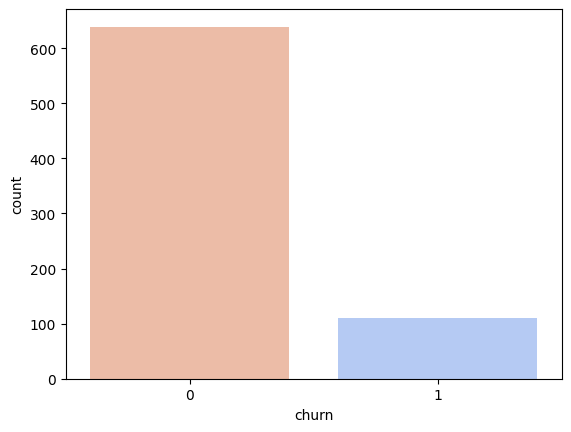

In [57]:
sns.countplot(x='churn', data=test, palette='coolwarm_r')

test['churn'].value_counts()